In [1]:
#Leitura e definição do dataframe dos dados medidos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from oauth2client.service_account import ServiceAccountCredentials
import gspread
import statsmodels.api as sm
from itertools import product 
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost as xgb
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
import sys
from sklearn.metrics import mean_absolute_error, r2_score
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.fbprophet import Prophet

sys.path.append("..")

# Função para ler dados de uma planilha para um DataFrame
def read_sheet_into_dataframe(credentials_filename, sheet_name, tab_name):
    scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/spreadsheets",
             "https://www.googleapis.com/auth/drive.file", "https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name(credentials_filename, scope)
    gc = gspread.authorize(creds)
    
    sheet = gc.open(sheet_name)
    worksheet = sheet.worksheet(tab_name)
    
    values = worksheet.get_all_values()
    
    df = pd.DataFrame(values[1:], columns=values[0])
    return df
#função para processar a coluna lida
def find_indices_first_last_non_empty(df, column_name):
    non_empty_indices = df[df[column_name] != ""].index
    first_non_empty_index = non_empty_indices[0]
    last_non_empty_index = non_empty_indices[-1]
    return first_non_empty_index, last_non_empty_index
#Função de treinamento e previsão
def sktime_forecast(dataset, horizon, forecaster, validation=False, confidence=0.95, frequency="W"):
    """Loop over a time series dataframe, train an sktime forecasting model, and visualize the results.

    Args:
        dataset (pd.DataFrame): Input time series DataFrame with datetime index
        horizon (int): Forecast horizon
        forecaster (sktime.forecasting): Configured forecaster
        validation (bool, optional): . Defaults to False.
        confidence (float, optional): Confidence level. Defaults to 0.9.
        frequency (str, optional): . Defaults to "D".
    """
    
    # Adjust frequency
    forecast_df = dataset.resample(rule=frequency).sum()

    # Interpolate missing periods (if any)
    forecast_df = forecast_df.interpolate(method="time")

    for col in dataset.columns:

        # Use train/test split to validate forecaster
        if validation:
            df = forecast_df[col]

            y_train = df[:-horizon]
            y_test = df.tail(horizon)

            forecaster.fit(y_train)
            fh = ForecastingHorizon(y_test.index, is_relative=False)
            y_pred = forecaster.predict(fh)
            ci = forecaster.predict_interval(fh, coverage=confidence).astype("float")
            y_true = df.tail(horizon)

            mae = mean_absolute_error(y_true, y_pred)

        # Make predictions beyond the dataset
        if not validation:
            df = forecast_df[col].dropna()
            forecaster.fit(df)

            last_date = df.index.max()
            fh = ForecastingHorizon(
                pd.date_range(str(last_date), periods=horizon, freq=frequency),
                is_relative=False,
            )

            y_pred = forecaster.predict(fh)
            ci = forecaster.predict_interval(fh, coverage=confidence).astype("float")
            mae = np.nan

        # Visualize results
        plt.plot(
            df,
            label="Actual",
            color="black",
        )
        plt.gca().fill_between(
            ci.index, (ci.iloc[:, 0]), (ci.iloc[:, 1]), color="b", alpha=0.1
        )
        plt.plot(y_pred, label="Predicted")
        plt.title(
             f"{horizon} week forecast for {col} (mae: {round(mae, 2)}, confidence: {confidence*100}%)"
        )
        plt.ylim(bottom=0)
        plt.legend()
        plt.grid(False)
        plt.xticks(rotation=45)
        plt.show()

# Informações para leitura dos dados
json_credentials_path = 'project-bht-e1805246c668.json'
sheet_name = 'Calibração de forecasts olx'
sheet_tab = 'Semanal'

# Ler os dados da planilha para um DataFrame
df = read_sheet_into_dataframe(json_credentials_path, sheet_name, sheet_tab)
#print(df)
#pegando nomes das colunas
column_names = df.columns.tolist()
column_names.pop(0) #tirar a coluna de semanas

#selecionando a coluna de datas e uma coluna de dados
date_col = 'Semana'  # Coluna das datas
data_col = 'leads_zap_vr'  # Coluna dos dados
start_row, end_row = find_indices_first_last_non_empty(df, data_col)

# Filtrar as colunas de interesse
df_filtered = df.loc[start_row-2:end_row, [date_col, data_col]]

##
# Converter as datas para datetime e os dados para numéricos
df_filtered[date_col] = pd.to_datetime(df_filtered[date_col], format='%Y-%m-%d')
df_filtered[data_col] = pd.to_numeric(df_filtered[data_col])
#df_filtered['Semana'] = df_filtered['Semana'] - pd.DateOffset(days=1)
df_filtered = df_filtered.set_index(date_col)

#Processamento dos dados medidos pra extrair somente a trend
data_series = df_filtered[data_col].dropna()
result = seasonal_decompose(data_series, model='multiplicative', period=4, extrapolate_trend='freq')
trend = result.trend
df_trend = df_filtered.copy()
df_trend[data_col]=trend
df=df_trend
print(df)


2023-10-09 17:38:10.827619: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-09 17:38:10.991892: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 17:38:12.145217: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 17:38:12.149119: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 17:38:13.829475: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

            leads_zap_vr
Semana                  
2019-06-10  4.453127e+04
2019-06-17  5.036400e+04
2019-06-24  5.973950e+04
2019-07-01  6.029338e+04
2019-07-08  6.070600e+04
...                  ...
2023-08-21  9.839669e+05
2023-08-28  1.020073e+06
2023-09-04  1.057112e+06
2023-09-11  1.085980e+06
2023-09-18  1.119295e+06

[224 rows x 1 columns]


            leads_zap_vr
Semana                  
2019-06-10       56561.0
2019-06-17       59662.0
2019-06-24       62782.0
2019-07-01       58694.0
2019-07-08       59079.0
...                  ...
2023-08-21     1051567.0
2023-08-28     1062670.0
2023-09-04      938286.0
2023-09-11     1132980.0
2023-09-18     1137456.0

[224 rows x 1 columns]


/home/jovyan/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

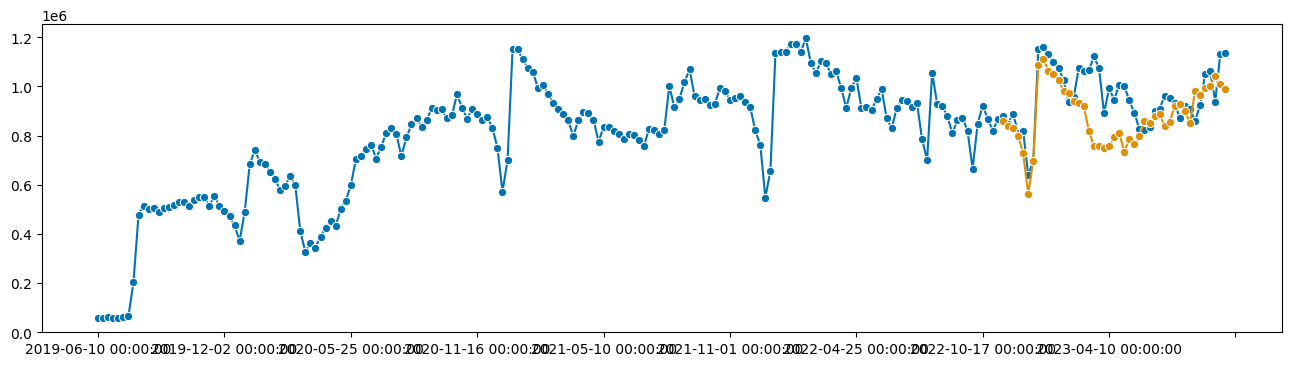

In [2]:
#y = df.asfreq('d').dropna()
y = df_filtered.asfreq('d').dropna()
print(y)
y_train, y_test = temporal_train_test_split(y,train_size=0.80) #dividindo em teste e treino
fh = ForecastingHorizon(y_test.index, is_relative=False) # definindo os indices da predição
forecaster = ThetaForecaster(sp=52)  # monthly seasonal periodicity #definindo o modelo de previsão
forecaster.fit(y_train) #treinando modelo
y_pred = forecaster.predict(fh) # calculando a previsão
mean_absolute_percentage_error(y_test, y_pred)
plot_series(y, y_pred)

17:38:35 - cmdstanpy - INFO - Chain [1] start processing
17:38:35 - cmdstanpy - INFO - Chain [1] done processing


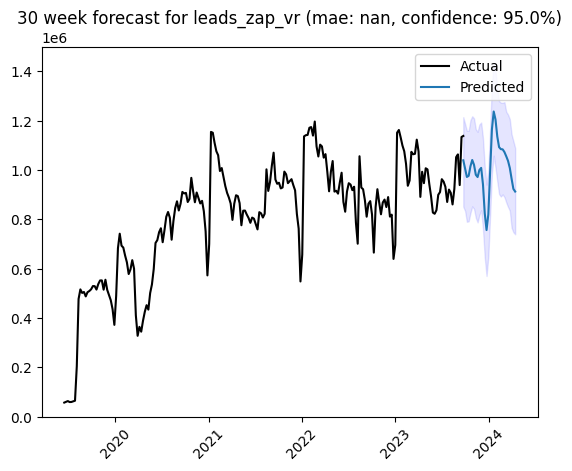

In [3]:
forecaster = Prophet(yearly_seasonality=True, weekly_seasonality=True)
sktime_forecast(dataset=y, horizon=30, forecaster=forecaster, validation=False)